In [1]:
import torch
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import copy
from tqdm import tqdm
import nevergrad as ng
import lpips

In [2]:
print(torch.__version__)

1.13.1


In [3]:
import os
os.environ["cuda_visible_devices"]='1'

# Choose variants here:

In [4]:
trained_model = False
arch = 'ResNet18'

## System setup:

In [5]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CelebA-64', defs, 
                                                                      data_path='/Users/manandkrishna/Documents/s2/VisualComputing/GGL')

model = torchvision.models.resnet18(pretrained=trained_model)
model.to(**setup)
model.eval();

Currently evaluating -------------------------------:
Sunday, 16. April 2023 04:22PM
CPUs: 8, GPUs: 0 on Ms-MacBook-Air.iith.ac.in.


/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
def plot(tensor):
    # define transformt o resize the image with given size
    transform = T.Resize(size = (64,64))
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    tensor = transform(tensor)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

In [ ]:
dm = torch.as_tensor([0.5, 0.5, 0.5])[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5])[:, None, None]

def plot1(tensor):
    # Define transforms to resize and crop the image
    resize_transform = T.Resize(size=(256, 256))
    five_crop_transform = T.FiveCrop(size=(128, 256))  # Get five crops (top-left, top-right, bottom-left, bottom-right, and center)
    
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    tensor = resize_transform(tensor)
    
    # Apply FiveCrop and select the top center crop (average of top-left and top-right crops)
    crops = five_crop_transform(tensor)
    top_center_crop = (crops[0] + crops[1]) / 2
    
    if tensor.shape[0] == 1:
        return plt.imshow(top_center_crop[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(top_center_crop):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

## BigGAN model

In [7]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal, convert_to_images)

In [8]:
# Load pre-trained model tokenizer (vocabulary)
generator= BigGAN.from_pretrained('biggan-deep-256').to(setup['device'])

print(setup['device'])

cpu


# Reconstruct

### Build the input (ground-truth) gradient

19962


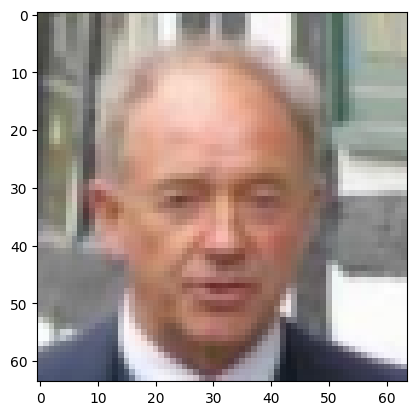

In [9]:
idx = 6565
img, label = validloader.dataset[idx] 
im1,_ = validloader.dataset[4] 
labels = torch.as_tensor((label,), device=setup['device'])
ground_truth = img.to(**setup).unsqueeze(0)
xtest=im1.to(**setup).unsqueeze(0)
plot(ground_truth)
#print([trainloader.dataset.classes[l] for l in labels]);
print(len(validloader.dataset))

In [10]:
ground_truth_denormalized = torch.clamp(ground_truth * ds + dm, 0, 1)
# torchvision.utils.save_image(ground_truth_denormalized, f'{idx}_{arch}_ImageNet_input.png')

In [11]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]
full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')
print(target_loss)

Full gradient norm is 7.873246e-01.
tensor(7.0215, grad_fn=<NllLossBackward0>)


# Reconstruction

In [12]:
import nevergrad as ng
from reconstructor import AdamReconstructor

In [ ]:
ng_rec = AdamReconstructor(fl_model=model, generator=generator, loss_fn=loss_fn,
                                     num_classes=1000, search_dim=(128,),lr=0.01, strategy='Adam', budget=2500, use_tanh=True, use_weight=False, defense_setting=None)
z_res, x_res, img_res, loss_res = ng_rec.reconstruct(input_gradient)

In [ ]:
plot1(x_res)

In [ ]:
ng_rec = AdamReconstructor(fl_model=model, generator=generator, loss_fn=loss_fn,
                                     num_classes=1000, search_dim=(128,),lr=0.01, strategy='Adam', budget=1000, use_tanh=True, use_weight=False, defense_setting='quantize_gradient')
z_res, x_res, img_res, loss_res = ng_rec.reconstruct(input_gradient)

In [ ]:
plot(x_res)

## Reconstruction with quantized gradients as defense setting -Novelty

In [13]:
import nevergrad as ng
from reconstructor import NGReconstructor

In [14]:
ng_rec = NGReconstructor(fl_model=model, generator=generator, loss_fn=loss_fn,
                                     num_classes=1000, search_dim=(128,), strategy='CMA', budget=500, use_tanh=True, defense_setting={'quantize_gradient'})
z_res, x_res, img_res, loss_res = ng_rec.reconstruct(input_gradient)

Inferred label: tensor([1])


Loss 0.314519: 100%|██████████████████████| 500/500 [16:55:30<00:00, 121.86s/it]


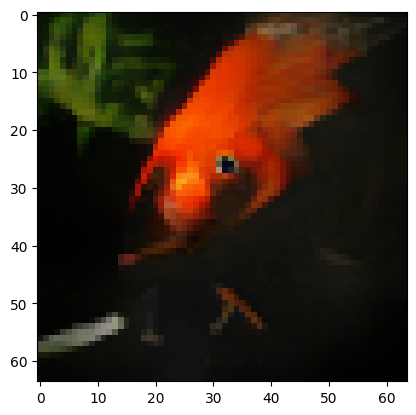

In [15]:
plot(x_res)

# Added Gradient Pruning - Novelty

In [ ]:
ng_rec = NGReconstructor(fl_model=model, generator=generator, loss_fn=loss_fn,
                                     num_classes=1000, search_dim=(128,), strategy='CMA', budget=500, use_tanh=True, defense_setting='pruning')
z_res, x_res1, img_res, loss_res = ng_rec.reconstruct(input_gradient)

## Reconstruction Authors method failed by my gradient pruning

In [ ]:
plot(xtest)

In [ ]:
original_img = ground_truth.mul_(ds).add_(dm).clamp_(0, 1).mul_(255).permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
res_img = x_res.mul_(ds).add_(dm).clamp_(0, 1).mul_(255).permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imsave(os.path.join('out/', 'original.png'), original_img)
plt.imsave(os.path.join('out/', 'GAN_out.png'), res_img)